# Centralized learning for ECG Arrhythmia detection


In [1]:
import configparser
import os
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from dataset_utils import Cinc2017DataModule
from model import DenseNetGruEcgModule

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config


In [2]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")

config = configparser.ConfigParser()
config.read("config.ini")
dst_freq = config.getint("data_preprocessing", "dst_freq")
dst_time = config.getint("data_preprocessing", "dst_time")
dst_length = dst_freq * dst_time

MAX_EPOCHS = 50

## Prepare the Dataset


In [3]:
dm = Cinc2017DataModule(batch_size=64)

## Create the Model


In [4]:
model = DenseNetGruEcgModule(
    max_epochs=MAX_EPOCHS,
    num_classes=dm.num_classes,
    input_length=dst_length,
    lr=1e-3,
    min_lr = 1e-5,
    show_valid_cm=True,
    growth_rate=16,
    block_config=(4, 4, 12, 8, 8, 8),
    num_init_features=64,
    bn_size=4,
    db_drop_rate=0.2,
    gru_drop_rate=0.2,
    fc_drop_rate=0.5,
    memory_efficient=False,
    compression_factor=0.5,
)

# the number of features per denseblock:
# (32 + 6 * 16) // 2 = 64
# (64 + 4 * 16) // 2 = 64
# (64 + 12 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (256 + 8 * 16) // 2 = 128

## Create the Trainer


In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_auprc",
    verbose=True,
    mode="max",
    save_top_k=1,
    save_last=True,
)

# early_stopping_callback = EarlyStopping(
#     monitor="valid_loss", patience=8, verbose=True, mode="min"
# )

progress_bar_callback = TQDMProgressBar(leave=True)

project_name = "awin-ecg-centralized"
if wandb_mode == "disabled":
    logger = TensorBoardLogger(save_dir=Path("tb_logs"), name=project_name)
else:
    logger = WandbLogger(
        project=project_name, save_dir=Path("wandb_logs"), log_model=True, name=project_name
    )

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the Model


In [6]:
trainer.fit(model, datamodule=dm)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devilhyt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes     | Out sizes
-----------------------------------------------------------------------------------------------
0 | model         | DenseNetGruEcg            | 1.3 M  | train | [1, 1, 6000] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?            | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?            | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?            | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?            | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?            | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?            | ?        
-----------------------------------------------------------------------------------------------
1.3 M     Trainable params
0         Non-trai

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 91/91 [00:17<00:00,  5.16it/s, v_num=e8fd, lr=0.001, valid_loss=1.280, valid_acc=0.286, valid_auprc=0.375, valid_auroc=0.583, valid_f1=0.281, train_loss=1.090, train_acc=0.369, train_auprc=0.374, train_auroc=0.547, train_f1=0.369]

Epoch 0, global step 91: 'valid_auprc' reached 0.37487 (best 0.37487), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=0-step=91.ckpt' as top 1



Valid Confusion Matrix:
tensor([[166, 349, 247],
        [  7,  86,  21],
        [ 71, 189, 102]], device='cuda:0')
Epoch 1: 100%|██████████| 91/91 [00:17<00:00,  5.15it/s, v_num=e8fd, lr=0.001, valid_loss=0.781, valid_acc=0.693, valid_auprc=0.580, valid_auroc=0.806, valid_f1=0.599, train_loss=0.968, train_acc=0.514, train_auprc=0.516, train_auroc=0.691, train_f1=0.479]
Valid Confusion Matrix:
tensor([[645,   5, 112],
        [ 20,  61,  33],
        [155,  55, 152]], device='cuda:0')


Epoch 1, global step 182: 'valid_auprc' reached 0.57969 (best 0.57969), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=1-step=182.ckpt' as top 1


Epoch 2: 100%|██████████| 91/91 [00:17<00:00,  5.14it/s, v_num=e8fd, lr=0.001, valid_loss=0.732, valid_acc=0.697, valid_auprc=0.737, valid_auroc=0.860, valid_f1=0.598, train_loss=0.805, train_acc=0.624, train_auprc=0.667, train_auroc=0.801, train_f1=0.614]


Epoch 2, global step 273: 'valid_auprc' reached 0.73694 (best 0.73694), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=2-step=273.ckpt' as top 1


Valid Confusion Matrix:
tensor([[642,  55,  65],
        [ 11,  97,   6],
        [127, 111, 124]], device='cuda:0')
Epoch 3: 100%|██████████| 91/91 [00:17<00:00,  5.14it/s, v_num=e8fd, lr=0.001, valid_loss=0.503, valid_acc=0.792, valid_auprc=0.807, valid_auroc=0.912, valid_f1=0.715, train_loss=0.636, train_acc=0.727, train_auprc=0.782, train_auroc=0.877, train_f1=0.716]
Valid Confusion Matrix:
tensor([[726,  12,  24],
        [  6,  98,  10],
        [146,  59, 157]], device='cuda:0')

Epoch 3, global step 364: 'valid_auprc' reached 0.80654 (best 0.80654), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=3-step=364.ckpt' as top 1



Epoch 4: 100%|██████████| 91/91 [00:17<00:00,  5.13it/s, v_num=e8fd, lr=0.001, valid_loss=0.527, valid_acc=0.788, valid_auprc=0.840, valid_auroc=0.913, valid_f1=0.725, train_loss=0.551, train_acc=0.774, train_auprc=0.834, train_auroc=0.909, train_f1=0.770]


Epoch 4, global step 455: 'valid_auprc' reached 0.84028 (best 0.84028), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=4-step=455.ckpt' as top 1


Valid Confusion Matrix:
tensor([[660,  40,  62],
        [  1, 110,   3],
        [ 80,  76, 206]], device='cuda:0')
Epoch 5: 100%|██████████| 91/91 [00:17<00:00,  5.12it/s, v_num=e8fd, lr=0.001, valid_loss=0.576, valid_acc=0.770, valid_auprc=0.821, valid_auroc=0.905, valid_f1=0.721, train_loss=0.500, train_acc=0.798, train_auprc=0.856, train_auroc=0.922, train_f1=0.797]
Valid Confusion Matrix:
tensor([[635,  24, 103],
        [  0, 104,  10],
        [ 87,  61, 214]], device='cuda:0')


Epoch 5, global step 546: 'valid_auprc' was not in top 1


Epoch 6: 100%|██████████| 91/91 [00:17<00:00,  5.10it/s, v_num=e8fd, lr=0.001, valid_loss=0.478, valid_acc=0.821, valid_auprc=0.851, valid_auroc=0.922, valid_f1=0.759, train_loss=0.456, train_acc=0.814, train_auprc=0.876, train_auroc=0.933, train_f1=0.811]

Epoch 6, global step 637: 'valid_auprc' reached 0.85064 (best 0.85064), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=6-step=637.ckpt' as top 1



Valid Confusion Matrix:
tensor([[715,  16,  31],
        [  3, 106,   5],
        [105,  61, 196]], device='cuda:0')
Epoch 7: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=e8fd, lr=0.001, valid_loss=0.443, valid_acc=0.840, valid_auprc=0.862, valid_auroc=0.931, valid_f1=0.803, train_loss=0.423, train_acc=0.831, train_auprc=0.892, train_auroc=0.942, train_f1=0.829]


Epoch 7, global step 728: 'valid_auprc' reached 0.86208 (best 0.86208), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=7-step=728.ckpt' as top 1


Valid Confusion Matrix:
tensor([[675,  10,  77],
        [  0, 101,  13],
        [ 61,  37, 264]], device='cuda:0')
Epoch 8: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=e8fd, lr=0.001, valid_loss=0.412, valid_acc=0.841, valid_auprc=0.874, valid_auroc=0.938, valid_f1=0.809, train_loss=0.412, train_acc=0.836, train_auprc=0.900, train_auroc=0.946, train_f1=0.835]

Epoch 8, global step 819: 'valid_auprc' reached 0.87428 (best 0.87428), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=8-step=819.ckpt' as top 1



Valid Confusion Matrix:
tensor([[697,   4,  61],
        [  1,  99,  14],
        [ 89,  28, 245]], device='cuda:0')
Epoch 9: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=e8fd, lr=0.001, valid_loss=0.431, valid_acc=0.839, valid_auprc=0.869, valid_auroc=0.930, valid_f1=0.810, train_loss=0.434, train_acc=0.827, train_auprc=0.890, train_auroc=0.941, train_f1=0.825]

Epoch 9, global step 910: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[679,  13,  70],
        [  1, 103,  10],
        [ 78,  27, 257]], device='cuda:0')
Epoch 10: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=e8fd, lr=0.001, valid_loss=0.419, valid_acc=0.837, valid_auprc=0.877, valid_auroc=0.939, valid_f1=0.798, train_loss=0.386, train_acc=0.848, train_auprc=0.909, train_auroc=0.951, train_f1=0.846]


Epoch 10, global step 1001: 'valid_auprc' reached 0.87696 (best 0.87696), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=10-step=1001.ckpt' as top 1


Valid Confusion Matrix:
tensor([[685,  14,  63],
        [  0, 106,   8],
        [ 77,  40, 245]], device='cuda:0')
Epoch 11: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=e8fd, lr=0.001, valid_loss=0.403, valid_acc=0.852, valid_auprc=0.884, valid_auroc=0.942, valid_f1=0.824, train_loss=0.370, train_acc=0.852, train_auprc=0.912, train_auroc=0.954, train_f1=0.851]

Epoch 11, global step 1092: 'valid_auprc' reached 0.88413 (best 0.88413), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=11-step=1092.ckpt' as top 1



Valid Confusion Matrix:
tensor([[686,   6,  70],
        [  0, 104,  10],
        [ 66,  31, 265]], device='cuda:0')
Epoch 12: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=e8fd, lr=0.001, valid_loss=0.466, valid_acc=0.829, valid_auprc=0.861, valid_auroc=0.926, valid_f1=0.789, train_loss=0.390, train_acc=0.840, train_auprc=0.905, train_auroc=0.950, train_f1=0.841]
Valid Confusion Matrix:
tensor([[674,  18,  70],
        [  0, 107,   7],
        [ 73,  44, 245]], device='cuda:0')


Epoch 12, global step 1183: 'valid_auprc' was not in top 1


Epoch 13: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=e8fd, lr=0.001, valid_loss=0.412, valid_acc=0.851, valid_auprc=0.878, valid_auroc=0.939, valid_f1=0.817, train_loss=0.334, train_acc=0.871, train_auprc=0.930, train_auroc=0.963, train_f1=0.872]


Epoch 13, global step 1274: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[697,   8,  57],
        [  0, 105,   9],
        [ 77,  34, 251]], device='cuda:0')
Epoch 14: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=e8fd, lr=0.001, valid_loss=0.461, valid_acc=0.812, valid_auprc=0.864, valid_auroc=0.930, valid_f1=0.769, train_loss=0.336, train_acc=0.873, train_auprc=0.928, train_auroc=0.962, train_f1=0.872]

Epoch 14, global step 1365: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[663,  15,  84],
        [  1, 107,   6],
        [ 73,  54, 235]], device='cuda:0')
Epoch 15: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.433, valid_acc=0.834, valid_auprc=0.877, valid_auroc=0.938, valid_f1=0.793, train_loss=0.321, train_acc=0.874, train_auprc=0.934, train_auroc=0.965, train_f1=0.873]


Epoch 15, global step 1456: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[691,  17,  54],
        [  1, 106,   7],
        [ 88,  39, 235]], device='cuda:0')
Epoch 16: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.397, valid_acc=0.847, valid_auprc=0.883, valid_auroc=0.941, valid_f1=0.818, train_loss=0.334, train_acc=0.872, train_auprc=0.928, train_auroc=0.962, train_f1=0.871]


Epoch 16, global step 1547: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[688,   5,  69],
        [  1, 103,  10],
        [ 73,  31, 258]], device='cuda:0')
Epoch 17: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.446, valid_acc=0.829, valid_auprc=0.880, valid_auroc=0.937, valid_f1=0.794, train_loss=0.330, train_acc=0.877, train_auprc=0.930, train_auroc=0.963, train_f1=0.877]


Epoch 17, global step 1638: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[649,  18,  95],
        [  0, 107,   7],
        [ 48,  44, 270]], device='cuda:0')
Epoch 18: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.414, valid_acc=0.842, valid_auprc=0.886, valid_auroc=0.945, valid_f1=0.826, train_loss=0.307, train_acc=0.885, train_auprc=0.939, train_auroc=0.968, train_f1=0.884]

Epoch 18, global step 1729: 'valid_auprc' reached 0.88630 (best 0.88630), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=18-step=1729.ckpt' as top 1



Valid Confusion Matrix:
tensor([[648,   5, 109],
        [  1, 101,  12],
        [ 45,  23, 294]], device='cuda:0')
Epoch 19: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.396, valid_acc=0.850, valid_auprc=0.894, valid_auroc=0.947, valid_f1=0.816, train_loss=0.316, train_acc=0.880, train_auprc=0.937, train_auroc=0.967, train_f1=0.879]

Epoch 19, global step 1820: 'valid_auprc' reached 0.89443 (best 0.89443), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=19-step=1820.ckpt' as top 1



Valid Confusion Matrix:
tensor([[687,  11,  64],
        [  0, 110,   4],
        [ 66,  41, 255]], device='cuda:0')
Epoch 20: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.410, valid_acc=0.851, valid_auprc=0.882, valid_auroc=0.945, valid_f1=0.806, train_loss=0.303, train_acc=0.884, train_auprc=0.941, train_auroc=0.969, train_f1=0.884]

Epoch 20, global step 1911: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[701,  14,  47],
        [  0, 102,  12],
        [ 71,  40, 251]], device='cuda:0')
Epoch 21: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.374, valid_acc=0.855, valid_auprc=0.890, valid_auroc=0.950, valid_f1=0.820, train_loss=0.290, train_acc=0.888, train_auprc=0.945, train_auroc=0.971, train_f1=0.887]

Epoch 21, global step 2002: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[688,   8,  66],
        [  1, 101,  12],
        [ 61,  32, 269]], device='cuda:0')
Epoch 22: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.508, valid_acc=0.777, valid_auprc=0.870, valid_auroc=0.928, valid_f1=0.775, train_loss=0.285, train_acc=0.895, train_auprc=0.945, train_auroc=0.971, train_f1=0.895]


Epoch 22, global step 2093: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[571,   5, 186],
        [  0, 101,  13],
        [ 44,  28, 290]], device='cuda:0')
Epoch 23: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.375, valid_acc=0.868, valid_auprc=0.893, valid_auroc=0.949, valid_f1=0.837, train_loss=0.291, train_acc=0.888, train_auprc=0.944, train_auroc=0.971, train_f1=0.886]

Epoch 23, global step 2184: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[708,   4,  50],
        [  2, 102,  10],
        [ 70,  28, 264]], device='cuda:0')
Epoch 24: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.001, valid_loss=0.382, valid_acc=0.864, valid_auprc=0.895, valid_auroc=0.949, valid_f1=0.832, train_loss=0.270, train_acc=0.902, train_auprc=0.949, train_auroc=0.973, train_f1=0.901]

Epoch 24, global step 2275: 'valid_auprc' reached 0.89465 (best 0.89465), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=24-step=2275.ckpt' as top 1



Valid Confusion Matrix:
tensor([[694,   9,  59],
        [  1,  99,  14],
        [ 60,  25, 277]], device='cuda:0')
Epoch 25: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.443, valid_acc=0.834, valid_auprc=0.893, valid_auroc=0.943, valid_f1=0.819, train_loss=0.244, train_acc=0.912, train_auprc=0.960, train_auroc=0.978, train_f1=0.913]

Epoch 25, global step 2366: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[641,   9, 112],
        [  0, 105,   9],
        [ 50,  25, 287]], device='cuda:0')
Epoch 26: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.388, valid_acc=0.863, valid_auprc=0.900, valid_auroc=0.951, valid_f1=0.837, train_loss=0.228, train_acc=0.912, train_auprc=0.965, train_auroc=0.981, train_f1=0.912]

Epoch 26, global step 2457: 'valid_auprc' reached 0.89964 (best 0.89964), saving model to 'wandb_logs/awin-ecg-centralized/pav1e8fd/checkpoints/epoch=26-step=2457.ckpt' as top 1



Valid Confusion Matrix:
tensor([[686,   9,  67],
        [  0, 102,  12],
        [ 58,  23, 281]], device='cuda:0')
Epoch 27: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.407, valid_acc=0.853, valid_auprc=0.888, valid_auroc=0.944, valid_f1=0.820, train_loss=0.231, train_acc=0.911, train_auprc=0.960, train_auroc=0.980, train_f1=0.911]


Epoch 27, global step 2548: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[689,  10,  63],
        [  0, 101,  13],
        [ 67,  29, 266]], device='cuda:0')
Epoch 28: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.471, valid_acc=0.834, valid_auprc=0.881, valid_auroc=0.940, valid_f1=0.817, train_loss=0.222, train_acc=0.915, train_auprc=0.965, train_auroc=0.982, train_f1=0.915]

Epoch 28, global step 2639: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[649,   8, 105],
        [  0, 106,   8],
        [ 56,  28, 278]], device='cuda:0')
Epoch 29: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.462, valid_acc=0.836, valid_auprc=0.882, valid_auroc=0.940, valid_f1=0.806, train_loss=0.219, train_acc=0.919, train_auprc=0.965, train_auroc=0.982, train_f1=0.919]

Epoch 29, global step 2730: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[664,  11,  87],
        [  1, 104,   9],
        [ 60,  35, 267]], device='cuda:0')
Epoch 30: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.463, valid_acc=0.838, valid_auprc=0.881, valid_auroc=0.938, valid_f1=0.809, train_loss=0.218, train_acc=0.920, train_auprc=0.965, train_auroc=0.982, train_f1=0.920]

Epoch 30, global step 2821: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[660,   6,  96],
        [  1, 100,  13],
        [ 51,  33, 278]], device='cuda:0')
Epoch 31: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.440, valid_acc=0.848, valid_auprc=0.891, valid_auroc=0.946, valid_f1=0.818, train_loss=0.216, train_acc=0.917, train_auprc=0.969, train_auroc=0.983, train_f1=0.916]


Epoch 31, global step 2912: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[669,   9,  84],
        [  1, 102,  11],
        [ 51,  32, 279]], device='cuda:0')
Epoch 32: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.459, valid_acc=0.829, valid_auprc=0.875, valid_auroc=0.935, valid_f1=0.799, train_loss=0.222, train_acc=0.921, train_auprc=0.962, train_auroc=0.981, train_f1=0.921]

Epoch 32, global step 3003: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[662,   9,  91],
        [  1, 101,  12],
        [ 66,  33, 263]], device='cuda:0')
Epoch 33: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.0005, valid_loss=0.398, valid_acc=0.855, valid_auprc=0.891, valid_auroc=0.946, valid_f1=0.827, train_loss=0.207, train_acc=0.926, train_auprc=0.968, train_auroc=0.984, train_f1=0.925]

Epoch 33, global step 3094: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[684,   7,  71],
        [  2,  99,  13],
        [ 62,  24, 276]], device='cuda:0')
Epoch 34: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.0005, valid_loss=0.435, valid_acc=0.851, valid_auprc=0.892, valid_auroc=0.942, valid_f1=0.830, train_loss=0.196, train_acc=0.928, train_auprc=0.973, train_auroc=0.985, train_f1=0.928]

Epoch 34, global step 3185: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[670,   4,  88],
        [  1, 101,  12],
        [ 54,  25, 283]], device='cuda:0')
Epoch 35: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.0005, valid_loss=0.454, valid_acc=0.859, valid_auprc=0.889, valid_auroc=0.942, valid_f1=0.829, train_loss=0.195, train_acc=0.928, train_auprc=0.971, train_auroc=0.985, train_f1=0.928]

Epoch 35, global step 3276: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[692,   6,  64],
        [  1, 102,  11],
        [ 64,  29, 269]], device='cuda:0')
Epoch 36: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.0005, valid_loss=0.470, valid_acc=0.846, valid_auprc=0.886, valid_auroc=0.941, valid_f1=0.808, train_loss=0.190, train_acc=0.930, train_auprc=0.975, train_auroc=0.987, train_f1=0.931]

Epoch 36, global step 3367: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[677,   8,  77],
        [  2,  98,  14],
        [ 55,  35, 272]], device='cuda:0')
Epoch 37: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.00025, valid_loss=0.432, valid_acc=0.857, valid_auprc=0.899, valid_auroc=0.945, valid_f1=0.838, train_loss=0.182, train_acc=0.934, train_auprc=0.974, train_auroc=0.987, train_f1=0.933]

Epoch 37, global step 3458: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[669,   5,  88],
        [  2, 104,   8],
        [ 49,  25, 288]], device='cuda:0')
Epoch 38: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.00025, valid_loss=0.446, valid_acc=0.860, valid_auprc=0.894, valid_auroc=0.943, valid_f1=0.832, train_loss=0.181, train_acc=0.934, train_auprc=0.975, train_auroc=0.987, train_f1=0.934]

Epoch 38, global step 3549: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[685,   9,  68],
        [  1, 104,   9],
        [ 58,  28, 276]], device='cuda:0')
Epoch 39: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.430, valid_acc=0.850, valid_auprc=0.896, valid_auroc=0.946, valid_f1=0.822, train_loss=0.178, train_acc=0.934, train_auprc=0.976, train_auroc=0.988, train_f1=0.933]

Epoch 39, global step 3640: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[670,   6,  86],
        [  2, 101,  11],
        [ 51,  30, 281]], device='cuda:0')
Epoch 40: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.440, valid_acc=0.868, valid_auprc=0.896, valid_auroc=0.945, valid_f1=0.835, train_loss=0.175, train_acc=0.937, train_auprc=0.975, train_auroc=0.988, train_f1=0.937]

Epoch 40, global step 3731: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[706,   7,  49],
        [  2, 103,   9],
        [ 68,  29, 265]], device='cuda:0')
Epoch 41: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.445, valid_acc=0.849, valid_auprc=0.889, valid_auroc=0.942, valid_f1=0.822, train_loss=0.164, train_acc=0.940, train_auprc=0.980, train_auroc=0.989, train_f1=0.939]

Epoch 41, global step 3822: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[676,   6,  80],
        [  2, 100,  12],
        [ 60,  27, 275]], device='cuda:0')
Epoch 42: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.00025, valid_loss=0.498, valid_acc=0.841, valid_auprc=0.887, valid_auroc=0.939, valid_f1=0.817, train_loss=0.170, train_acc=0.938, train_auprc=0.977, train_auroc=0.989, train_f1=0.938]

Epoch 42, global step 3913: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[651,   8, 103],
        [  1, 101,  12],
        [ 45,  28, 289]], device='cuda:0')
Epoch 43: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=e8fd, lr=0.00025, valid_loss=0.474, valid_acc=0.853, valid_auprc=0.886, valid_auroc=0.943, valid_f1=0.825, train_loss=0.166, train_acc=0.942, train_auprc=0.978, train_auroc=0.989, train_f1=0.942]

Epoch 43, global step 4004: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[684,   8,  70],
        [  1, 101,  12],
        [ 65,  26, 271]], device='cuda:0')
Epoch 44: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.474, valid_acc=0.858, valid_auprc=0.889, valid_auroc=0.942, valid_f1=0.830, train_loss=0.163, train_acc=0.940, train_auprc=0.980, train_auroc=0.990, train_f1=0.939]

Epoch 44, global step 4095: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[683,   5,  74],
        [  2, 101,  11],
        [ 56,  28, 278]], device='cuda:0')
Epoch 45: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.448, valid_acc=0.860, valid_auprc=0.895, valid_auroc=0.946, valid_f1=0.832, train_loss=0.162, train_acc=0.944, train_auprc=0.980, train_auroc=0.990, train_f1=0.943]

Epoch 45, global step 4186: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[695,   6,  61],
        [  2, 101,  11],
        [ 68,  25, 269]], device='cuda:0')
Epoch 46: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.507, valid_acc=0.847, valid_auprc=0.891, valid_auroc=0.943, valid_f1=0.829, train_loss=0.154, train_acc=0.944, train_auprc=0.982, train_auroc=0.991, train_f1=0.944]


Epoch 46, global step 4277: 'valid_auprc' was not in top 1


Valid Confusion Matrix:
tensor([[657,   7,  98],
        [  1, 103,  10],
        [ 51,  23, 288]], device='cuda:0')
Epoch 47: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.486, valid_acc=0.850, valid_auprc=0.889, valid_auroc=0.942, valid_f1=0.820, train_loss=0.156, train_acc=0.942, train_auprc=0.982, train_auroc=0.991, train_f1=0.943]

Epoch 47, global step 4368: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[677,  10,  75],
        [  2, 101,  11],
        [ 60,  28, 274]], device='cuda:0')
Epoch 48: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.506, valid_acc=0.852, valid_auprc=0.884, valid_auroc=0.939, valid_f1=0.812, train_loss=0.161, train_acc=0.942, train_auprc=0.980, train_auroc=0.990, train_f1=0.941]

Epoch 48, global step 4459: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[695,  12,  55],
        [  2, 102,  10],
        [ 68,  36, 258]], device='cuda:0')
Epoch 49: 100%|██████████| 91/91 [00:17<00:00,  5.06it/s, v_num=e8fd, lr=0.00025, valid_loss=0.520, valid_acc=0.833, valid_auprc=0.885, valid_auroc=0.935, valid_f1=0.805, train_loss=0.154, train_acc=0.944, train_auprc=0.982, train_auroc=0.991, train_f1=0.945]

Epoch 49, global step 4550: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[649,  12, 101],
        [  1, 100,  13],
        [ 51,  29, 282]], device='cuda:0')


`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate on the Test Set


In [7]:
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from torchmetrics.aggregation import CatMetric, MeanMetric
from torchmetrics.functional.classification import (
    multiclass_auroc,
    multiclass_average_precision,
)


def aggregate_metrics(results):
    loss_metric = MeanMetric()
    y_pred_metric = CatMetric()
    y_metric = CatMetric()

    for result in results:
        loss_metric.update(result["loss"])
        y_pred_metric.update(result["y_pred"])
        y_metric.update(result["y"])
    loss = loss_metric.compute()
    y_pred = y_pred_metric.compute()
    y = y_metric.compute().to(torch.long)
    y_hat = y_pred.argmax(dim=1).to(torch.long)

    return loss, y_pred, y, y_hat

### Last model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 20.74it/s]
test_loss: 0.5400816202163696
test_auprc: 0.8642532825469971
test_auroc: 0.9304822087287903
              precision    recall  f1-score   support

           N       0.93      0.83      0.88       762
           A       0.73      0.87      0.80       114
           O       0.68      0.80      0.74       362

    accuracy                           0.82      1238
   macro avg       0.78      0.83      0.80      1238
weighted avg       0.84      0.82      0.83      1238



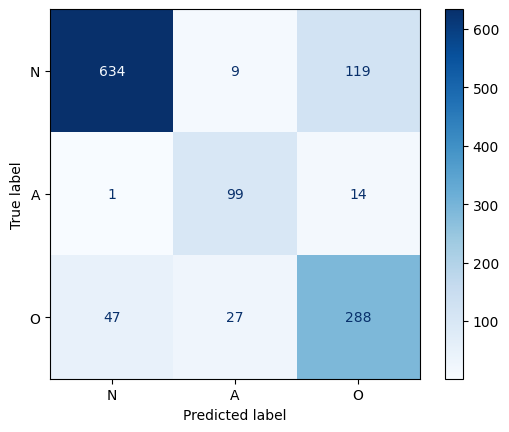

In [8]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.last_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"last_test_loss": test_loss.item()})
    wandb.log({"last_test_auprc": test_auprc.item()})
    wandb.log({"last_test_auroc": test_auroc.item()})
    wandb.log({"last_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"last_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"last_test_cm": test_cm_disp.figure_})

### Best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 20.73it/s]
test_loss: 0.43931612372398376
test_auprc: 0.8798181414604187
test_auroc: 0.9383828043937683
              precision    recall  f1-score   support

           N       0.92      0.90      0.91       762
           A       0.79      0.83      0.81       114
           O       0.76      0.78      0.77       362

    accuracy                           0.86      1238
   macro avg       0.82      0.84      0.83      1238
weighted avg       0.86      0.86      0.86      1238



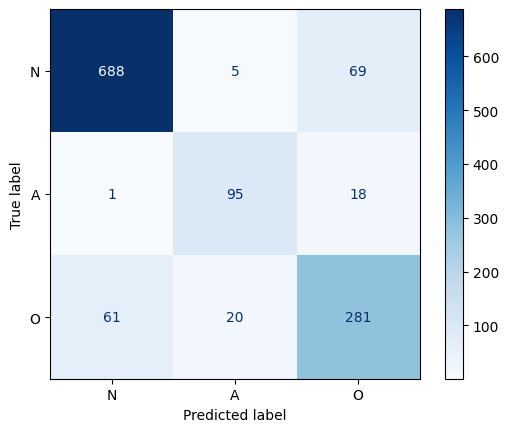

In [9]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.best_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"best_test_loss": test_loss.item()})
    wandb.log({"best_test_auprc": test_auprc.item()})
    wandb.log({"best_test_auroc": test_auroc.item()})
    wandb.log({"best_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"best_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"best_test_cm": test_cm_disp.figure_})

In [10]:
wandb.finish()

best_test_accuracy,▁
best_test_auprc,▁
best_test_auroc,▁
best_test_f1,▁
best_test_loss,▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
last_test_accuracy,▁
last_test_auprc,▁
last_test_auroc,▁
last_test_f1,▁
last_test_loss,▁
